# Coffea-Casa Benchmark Example 2

In [1]:
import numpy as np
%matplotlib inline
import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program plots a per-event array (in this case, Jet pT). In Coffea, this is not very dissimilar from the event-level process.

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="dataset", label="", categories=[], growth=True)
        Jet_axis = hist.axis.Regular(name="Jet_pt", label="Jet_pt [GeV]", bins=50, start=15, stop=60)
        
        self.output = processor.dict_accumulator({
            'Jet_pt': hist.Hist(dataset_axis, Jet_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    def process(self, events):
        dataset = events.metadata['dataset']
        Jet_pt = events.Jet.pt
        # As before, we can get the number of events by checking the size of the array. To get the number of jets, which varies per event, though, we need to count up the number in each event, and then sum those counts (count subarray sizes, sum them).
        self.output['cutflow']['all events'] += ak.size(Jet_pt, axis=0)
        self.output['cutflow']['all jets'] += ak.sum(ak.count(Jet_pt, axis=1))
        
        # .flatten() removes jaggedness; plotting jagged data is meaningless, we just want to plot flat jets.
        self.output['Jet_pt'].fill(dataset=dataset, Jet_pt=ak.flatten(Jet_pt))
        
        return self.output
    
    def postprocess(self, accumulator):
        pass

In [3]:
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

{'bytesread': 1612443666,
 'columns': ['Jet_pt', 'nJet'],
 'entries': 53446198,
 'processtime': 432.0077931880951,
 'chunks': 534}

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f719cfab9d0>, errorbar=None, legend_artist=None)]

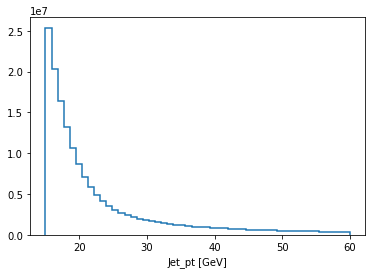

In [5]:
output['Jet_pt'].plot1d()

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all jets 170952895
